In [1]:
from fastai.text import *
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import sentencepiece as spm
import re
import pdb

In [2]:
import fastai, torch
fastai.__version__ , torch.__version__

('1.0.40', '1.0.0')

In [3]:
torch.cuda.set_device(0)

In [4]:
!pwd

/home/gaurav/PycharmProjects/nlp-for-gujarati/classification


In [5]:
path = Path('/home/gaurav/PycharmProjects/nlp-for-gujarati/classification')

In [6]:
!ls

Gujarati_Classification_Data_News_Headlines.csv
Gujarati_Classification_Model.ipynb


In [7]:
df = pd.read_csv(path/'Gujarati_Classification_Data_News_Headlines.csv')
df.tail()

,headline,label
6582,આ ફોનની બેટરી 0% થયા પછી પણ કરી શકશો અડધો કલાક...,tech
6583,ફેસબુકનો ઉપયોગ કરવા માટે આપવા પડી શકે છે હવે પ...,tech
6584,AI આસિસ્ટેન્ટ ફીચર્સની સાથે લોન્ચ થયો Z18 મિની...,tech
6585,"સાવધાન! પાક. અને ચીનની જાસૂસ છે આ Apps, તુરંત ...",tech
6586,77.3 કરોડ લોકોના ઇ-મેલ આઈડી થયા હેક: તમારું પણ...,tech


In [8]:
df['label'].unique()

array(['entertainment', 'business', 'tech'], dtype=object)

In [9]:
print('Entertainment', (df['label'] == 'entertainment').sum())
print('Business', (df['label'] == 'business').sum())
print('Tech', (df['label'] == 'tech').sum())

Entertainment 2905
Business 2331
Tech 1351


In [10]:
df['headline'][0]

"'મનમર્ઝિયા' જોઇને વિકી કૌશલનાં ફેન થયા 'મહાનાયક', મોકલી ખાસ ભેટ"

In [11]:
df.shape

(6587, 2)

In [12]:
df[df['headline'].isnull()].shape

(0, 2)

In [13]:
label_cols = list(range(1,df.shape[1]))

In [14]:
print(label_cols)

[1]


In [15]:
id_to_col = list(df.columns)

In [16]:
col_to_id = {}
for i, col in enumerate(id_to_col):
    col_to_id[col] = i

In [17]:
class GujaratiTokenizer(BaseTokenizer):
    def __init__(self, lang:str):
        self.lang = lang
        self.sp = spm.SentencePieceProcessor()
        self.sp.Load(str(path/"../tokenizer/gujarati_lm.model"))
        
    def tokenizer(self, t:str) -> List[str]:
        return self.sp.EncodeAsPieces(t)

In [18]:
sp = spm.SentencePieceProcessor()
sp.Load(str(path/"../tokenizer/gujarati_lm.model"))
itos = [sp.IdToPiece(int(i)) for i in range(20000)]

In [19]:
itos

['<unk>',
 '<s>',
 '</s>',
 '.',
 ',',
 '▁છે',
 '▁',
 '▁અને',
 'ની',
 'માં',
 'ના',
 '▁આ',
 'ને',
 '▁જ',
 '▁એક',
 '▁તેમ',
 '▁આવેલા',
 'નો',
 'નું',
 '▁કે',
 '▁ગામમાં',
 '▁ખેતી',
 '▁પણ',
 '▁માટે',
 'થી',
 '▁આવે',
 '▁ભાગમાં',
 '▁કરવામાં',
 '▁તે',
 'ો',
 'ે',
 '▁q',
 '▁�',
 'ી',
 '-',
 '▁ગામ',
 '▁પર',
 '▁હતી',
 '▁ભારત',
 '▁ગુજરાત',
 '▁મુખ્ય',
 '▁જે',
 'X',
 '▁આવેલું',
 '▁હતા',
 '▁સ્થાન',
 'એ',
 '▁એ',
 '▁હતો',
 '▁પશ્ચિમ',
 '▁ડેરી',
 '▁રાજ્યના',
 '▁દેશના',
 '▁ભારતમાં',
 '▁મુખ્યત્વે',
 '▁સાથે',
 '▁શાળા',
 '▁હતું',
 '▁જેવી',
 'ં',
 '▁પ્રાથમિક',
 '▁કરી',
 '▁દૂધ',
 '▁અન્ય',
 '▁પશુપાલન',
 '▁ગામના',
 '▁હોય',
 '▁ખેતમજૂરી',
 '▁આંગણવાડી',
 '▁વ્યવસાય',
 '▁પંચાયતઘર',
 '�',
 '▁પ્રાપ્ય',
 '▁સવલતો',
 '▁તરીકે',
 '▁લોકોનો',
 '▁તાલુકામાં',
 'ગુજરાત',
 '▁જિલ્લામાં',
 '▁પાક',
 '▁દ્વારા',
 '▁કરે',
 '▁થયેલી',
 'ા',
 '▁શાકભાજીના',
 '▁કુલ',
 '▁એવા',
 '▁થાય',
 'ક',
 '▁રીતે',
 'ન',
 'સ',
 '▁બાજરી',
 'ર',
 '▁પૈકીના',
 '▁લોકો',
 '▁કપાસ',
 '▁તેઓ',
 '▁"',
 '▁તાલુકાઓ',
 '▁તેના',
 'નાં',
 '"',
 'લ',
 'ઓ',
 '▁ઘઉં',
 '▁વધુ

In [20]:
# 20,000 is the vocab size that we chose in sentencepiece
gujarati_vocab = Vocab(itos)

In [21]:
tokenizer = Tokenizer(tok_func=GujaratiTokenizer, lang='gu')

In [22]:
tokenizer.special_cases

['xxunk', 'xxpad', 'xxbos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep']

In [23]:
data_lm = TextDataBunch.from_csv(path=path, csv_name='Gujarati_Classification_Data_News_Headlines.csv', text_cols=[0], label_cols=label_cols, tokenizer=tokenizer, vocab=gujarati_vocab)

In [24]:
data_lm.save()

In [25]:
bs=48

In [26]:
data_lm = TextLMDataBunch.load(path, 'tmp', bs=bs)

In [27]:
data_lm.show_batch()

idx,text
0,"▁x x bo s ▁સુઝુકી ▁વિ ટા રા ના ▁વધુ ▁બે ▁વેર િએ ન્ટ ▁લોન્ચ , ▁જાણ ો ▁કિંમત ▁અને ▁ફિચર ▁x x bo s ▁બુધવાર ે ▁આ ▁રીતે ▁ગણેશજી ની ▁કરેલી ▁પૂજા થી ▁ઘરમાં ▁સુખ - શાંતિ ▁આવે ▁છે ▁x x bo s ▁રૂ . 2 500 માં ▁હવે ▁આકાશમાં ▁ઉડ ો , પી એમ ▁મોદી એ ▁સસ્તી ▁ઉડાન ▁સેવા નો ▁કરાવ્યો ▁પ્રારંભ ▁x x bo s ▁v"
1,"▁h o t ▁p ic s , ▁જોતા ▁રહી ▁જ શો ▁તમે ▁પણ ▁x x bo s ▁g q ▁s t y l e ▁a w a r d s ▁20 18 : ▁બોલિવૂડ ▁સે બે બ્સ એ ▁બતાવ્યો ▁ફેશન નો ▁જ લવા ▁x x bo s ▁અરબ ા ઝ ▁ખાન ને ▁ફોન ▁પર ▁ધ મક ાવ તો ▁હતો ▁સ ટ્ટો ડિયો ▁સો નુ ,"
2,"િયન ▁કિ મ ▁કાર્ દિ શિયન ે ' ▁શેર ▁કરી ▁બોલ ્ડ ▁તસવીરો , ▁ઇન્ સ્ટા ગ્રામ ▁પર ▁થઇ ▁વાઇ રલ ▁x x bo s ▁ x ia om i ▁મોંઘા ▁સ્માર્ટફોન ▁અને ▁ડિવાઇસ ▁માત્ર ▁1 ▁રૂપિયા માં , ▁જાણ ો ▁શું ▁છે ▁આ ▁ખાસ ▁f la sh ▁sa le ▁x x bo s ▁ઘોડ ી ▁પર ▁નહીં ▁પણ ▁આ ▁ખાસ ▁અંદાજ માં ▁જાન ▁લઇને ▁આવશે ▁રણ વીર ▁x"
3,"લૂ ઝર ' ▁ક ંગ ના ▁સાથે ▁કરી ▁ચૂક્યા ▁છે ▁બ્રેક અપ ! ▁x x bo s ▁આ ▁વર્ષે ▁નહીં ▁થાય ▁રણ વીર - દીપ િકા નાં ▁લગ્ન , ▁રણ વી રે ▁જણાવ્યું ▁કારણ ▁x x bo s ▁ટેક્સ ટાઇ લ ▁સેક્ટર ને ▁600 ▁કરોડ ના ▁પેકેજ ની ▁નાણા મંત્રી ▁અરૂણ ▁જેટલી ની ▁જાહેરાત ▁x x bo s ▁5 ▁નહીં ▁8 ▁કરોડ ▁ફેસબુક ▁યૂ ઝર ્સના ▁લી ક ▁થયેલા ▁ડેટા"
4,"▁શાહરૂખ ▁ખાન ▁સાથે ▁કર્યો ▁' ર શ્ કે ▁કમ ર ▁પર ▁ડાન્સ ' ▁x x bo s ▁ગુજરાત ▁બજેટ ▁20 17 ▁l iv e : ▁ખેડૂતો ને ▁1 ▁ટકા ના ▁વ્યાજ ે ▁પાક ▁લોન ▁મળશે , ▁વિદ્યાર્થીઓ ને ▁ટેબલ ેટ ▁અપ ાશે ▁x x bo s ▁અક્ષય ▁કુમાર ▁અને ▁બોબ ી ▁દે ઓ લે ▁મોડી રાત ▁સુધી ▁કરી ▁પાર્ટી , ▁તસવીરો ▁x x bo s ▁સુરત :"


In [28]:
learn = language_model_learner(data_lm, drop_mult=0.3)

In [29]:
# Loading the pretrained language model on gujarati wikipedia
learn.load('/home/gaurav/PycharmProjects/nlp-for-gujarati/language-model/GujaratiDataset/models/third_gu_lm', with_opt=True)

LanguageLearner(data=TextLMDataBunch;

Train: LabelList
y: LMLabel (5269 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: /home/gaurav/PycharmProjects/nlp-for-gujarati/classification
x: LMTextList (5269 items)
[Text ▁x x bo s ▁પ્રિય ં કા - નિક ▁આપશે ▁ચોથુ ં ▁રિ સે પ્શન , ▁આ ▁જગ્યાએ ▁કરશે ▁સે લિ બ્ર ેશન, Text ▁x x bo s <unk> ▁b ig g ▁bo s s - 12 : ▁સલમાન ે ▁આ ▁સ્પર્ધક ને ▁કહ્યું , ▁કઇ ▁વાત નો ▁ઘ મ ંડ ▁છે ▁ત ને ?, Text ▁x x bo s ▁4 ▁દિવસ ▁પણ ▁રાહ ▁ન ▁જોઈ ▁શક્યો ▁આનંદ ▁આ હુ જા , ▁સોન મ ને ▁મળવા ▁માટે ▁પહોંચ્યો ▁મુંબઈ, Text ▁x x bo s <unk> ▁f ace b ook ▁બાદ ▁હવે <unk> ▁w hat sa ap થી ▁ડાઉનલોડ ▁કરી ▁શક શો ▁પોતાના ▁પર્સનલ ▁ડેટા, Text ▁x x bo s ▁ગુજરાત ે ▁વિકાસની ▁વિરાટ તાના ▁દર્શન ▁કરાવ્યા , ▁25 ▁હજાર <unk> u ▁થયા , ▁શું ▁છે ▁ખાસ ? ▁જાણ ો]...
Path: /home/gaurav/PycharmProjects/nlp-for-gujarati/classification;

Valid: LabelList
y: LMLabel (1318 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: /home/gaurav/PycharmProjects/nlp-for-gujarati

In [30]:
# Fine tuning the prtrained LM on current dataset

In [31]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


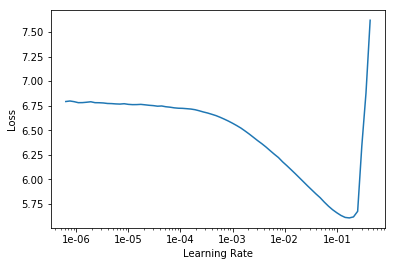

In [32]:
learn.recorder.plot()

In [33]:
learn.freeze()

In [34]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,5.703078,5.156730,0.262434


In [35]:
learn.save('fit_head', with_opt=True)

In [36]:
learn.load('fit_head', with_opt=True);

In [37]:
learn.unfreeze()

In [38]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,4.958479,4.915406,0.277381
2,4.716837,4.509920,0.306548
3,4.439901,4.252193,0.337500
4,4.176772,4.102649,0.356382
5,3.943571,4.016101,0.368948
6,3.737647,3.967003,0.375397
7,3.566721,3.947245,0.379696
8,3.437576,3.936263,0.382275
9,3.348205,3.936708,0.382077
10,3.297971,3.935233,0.382110


In [39]:
learn.save('fine_tuned', with_opt=True)

In [40]:
learn.load('fine_tuned', with_opt=True);

In [42]:
learn.predict('શાહરૂખ ખાન સાથે',n_words=10)

'શાહરૂખ ખાન સાથે ▁વિવાદ ic r ▁- ▁વ્યક્ત si m ▁ચુક si m'

In [43]:
learn.save_encoder('fine_tuned_enc')

In [45]:
data_clas = TextClasDataBunch.from_csv(path=path, csv_name='Gujarati_Classification_Data_News_Headlines.csv', tokenizer=tokenizer, vocab=gujarati_vocab, text_cols=[0], label_cols=label_cols)

In [46]:
data_clas.show_batch()

text,target
▁x x bo s ▁t r a i l e r u t : ▁જુઓ ▁' z e r o ' માં ▁શાહરૂખ - ▁અનુ ષ્ કા ▁અને ▁સેક્સ ી ▁કે ટર િના નું ▁l o v e ▁t r i a n g l e,entertainment
"▁x x bo s ▁a ma z on ▁પર ▁ચાલી ▁રહી ▁છે ▁a pp le ▁f est , ▁i p h one ▁ x થી ▁લઇને ▁i p h one ▁ ▁સુધી ▁ભારે ▁ડિસ્ક ાઉ ન્ટ",tech
"▁x x bo s ▁ ▁me t o o ▁: ▁ક ંગ ના ▁રન ૌ ટ ▁પર ▁ભડક ી ▁વિકાસ ▁બહ લ ની ▁પત્ની , ▁કહ્યું ▁' આ ટ લા ▁દિવસ થી ▁ચુ પ ▁કેમ ▁હતી ▁તો ? '",entertainment
▁x x bo s ▁t r iv i a : ▁' વીર - ઝા રા ' ▁ નાં ▁સો ન્ગ નો ▁કિસ્સો ▁જાણ ્યા ▁વગર ▁હિન્દી ▁ગીતો નાં ▁જ બર ાં ▁ ફેન ▁ન ▁બની ▁શકાય ?,entertainment
▁x x bo s ▁e x c l us iv e ▁i n t e r v i e w : ▁એચ -1 બી ▁વી ઝા ▁અમેરિકા નો ▁આ ંતરીક ▁મુદ્દો ઃ જે ટલી,business


In [47]:
data_clas.sanity_check()

In [48]:
learn = text_classifier_learner(data_clas, drop_mult=0.5)

In [49]:
learn.load_encoder('fine_tuned_enc')

In [50]:
learn.freeze()

In [51]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


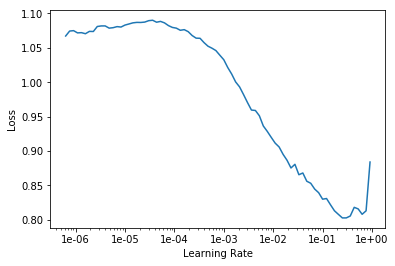

In [52]:
learn.recorder.plot()

In [53]:
learn.loss_func.func

CrossEntropyLoss()

In [54]:
kappa = KappaScore()

In [55]:
learn.metrics = [kappa, accuracy]

In [56]:
learn.fit_one_cycle(1, 1e-1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,kappa_score,accuracy
1,0.556412,0.354645,0.786694,0.862671


In [57]:
learn.save('first-full')

In [58]:
learn.load('first-full');

In [59]:
learn.freeze_to(-2)
learn.fit_one_cycle(5, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,kappa_score,accuracy
1,0.495619,0.301899,0.810159,0.879363
2,0.411036,0.271846,0.836352,0.895296
3,0.329943,0.247750,0.853615,0.906677
4,0.253060,0.261082,0.862736,0.911988
5,0.206439,0.265496,0.856568,0.908194


In [60]:
learn.save('final')

In [61]:
learn.predict('પ્રિયંકા ચોપડાને પતિ નિક પાસેથી મળી 2.7 કરોડ રૂપિયાની ગિફ્ટ, કિસ કરીને બોલી- લવ યૂ બેબી')

(Category entertainment,
 tensor(1),
 tensor([9.7322e-04, 9.9889e-01, 1.3541e-04]))

In [62]:
learn.predict("કલંકઃ 21 વર્ષ બાદ એકસાથે જોવા મળશે સંજય દત્ત-માધુરી દિક્ષિત, કહી દિલની વાત")

(Category entertainment,
 tensor(1),
 tensor([7.7836e-04, 9.9912e-01, 9.9804e-05]))

In [63]:
learn.predict("બે અઠવાડિયા બાદ સસ્તું થયું પેટ્રોલ, ડીઝલની કિંમત પણ ઘટી")

(Category business, tensor(0), tensor([9.9652e-01, 1.8823e-04, 3.2919e-03]))

In [65]:
learn.predict("જનકલી નોટો ઓળખવા માટે એક નવી સ્માર્ટફોન એપ આવી")

(Category tech, tensor(2), tensor([0.0864, 0.1449, 0.7687]))